Peter Torosian  
Data Bootcamp MBA  
5/12/16
<h3 align="center">Craft Brewery Project</h3> 

Author: Peter Torosian

I was interested in investigating the increase of craft beer production and brewery openings over the past decade.  In particular, I wanted to visualize clusters of breweries and where the growth of craft brewing has been over the past few years.

The final graph shows surprising growth in states like Pennsylvania, Wisconsin and Florida.  It is also interesting to see the states that produce the most craft beer per resident.

# Import Internet Data
Some open source brewery data is found on the https://openbeerdb.com/ website.

The dataframes that I have uploaded for my project include: production data for all microbreweries in the US, provided by Brewers Association and an open source directory of microbreweries that include their location data.

In [295]:
# import packages 
import pandas as pd                   # data management
import matplotlib.pyplot as plt       # graphics 
import numpy as np                     # foundation for Pandas
import seaborn.apionly as sns          # fancy matplotlib graphics (no styling)

import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 

from geopy.geocoders import Nominatim      #import geopy for getting geocodes
geolocator = Nominatim()                   #first must install geopy using "pip install geopy"

# plotly imports
from plotly.offline import iplot, iplot_mpl  # plotting functions
import plotly.graph_objs as go               # plotting functions
import plotly                                # just to print version and init notebook
import cufflinks as cf                       # gives us df.iplot that feels like df.plot
cf.set_config_file(offline=True, offline_show_link=False)

# these lines make our graphics show up in the notebook
%matplotlib inline             
plotly.offline.init_notebook_mode()


# check Python version 
import datetime as dt 
import sys
print('Today is', dt.date.today())
print('What version of Python are we running? \n', sys.version, sep='')
print('Plotly version: ', plotly.__version__)
print('Pandas version: ', pd.__version__)

print('Peter Torosian')

Today is 2016-05-12
What version of Python are we running? 
3.5.1 |Anaconda 4.0.0 (x86_64)| (default, Dec  7 2015, 11:24:55) 
[GCC 4.2.1 (Apple Inc. build 5577)]
Plotly version:  1.9.7
Pandas version:  0.18.0
Peter Torosian


In [296]:
# get "response" from url 
url = 'http://openbeerdb.com/files/openbeerdb_csv.zip'
r = requests.get(url) 

# describe response 
print('Response status code:', r.status_code)
print('Response type:', type(r))
print('Response .content:', type(r.content)) 
print('Response headers:\n', r.headers, sep='')
    

Response status code: 200
Response type: <class 'requests.models.Response'>
Response .content: <class 'bytes'>
Response headers:
{'Last-Modified': 'Mon, 25 Jan 2016 23:09:03 GMT', 'ETag': '"8cb9a-52a30a7adeea1"', 'Content-Length': '576410', 'Keep-Alive': 'timeout=5, max=100', 'Connection': 'Keep-Alive', 'Content-Type': 'application/zip', 'Server': 'Apache/2.4.10 (Debian)', 'Accept-Ranges': 'bytes', 'Date': 'Fri, 13 May 2016 02:56:56 GMT'}


In [297]:
# convert bytes to zip file  
br = zf.ZipFile(io.BytesIO(r.content)) 
print('Type of zipfile object:', type(br))

Type of zipfile object: <class 'zipfile.ZipFile'>


In [298]:
# what's in the zip file?
br.namelist()

['openbeerdb_csv/beers.csv',
 'openbeerdb_csv/breweries.csv',
 'openbeerdb_csv/breweries_geocode.csv',
 'openbeerdb_csv/categories.csv',
 'openbeerdb_csv/styles.csv',
 'openbeerdb_csv/']

In [299]:
# set csv files imported to dataframes
breweries = pd.read_csv(br.open(br.namelist()[1]))  #this file is a list of breweries and addresses, etc
geocode = pd.read_csv(br.open(br.namelist()[2]))    #this file is only brewery IDs and Lat/Long positions

In [300]:
# rename id column to brewery id so it matches with geocode file
breweries = breweries.rename(columns={'id': 'brewery_id'})

In [301]:
# merge the two dataframes
geobrew = pd.merge(breweries, geocode,
                  how = 'left',
                  on='brewery_id')

In [302]:
#reduce dataframe to only breweries in the United States
USA = geobrew['country'] == 'United States'
geobrewUSA = geobrew[USA]
#clean up bad data: bad data found during cleanup later in the notebook
geobrewUSA = geobrewUSA[geobrewUSA.brewery_id != 353]
geobrewUSA = geobrewUSA[geobrewUSA.brewery_id != 1184]

In [303]:
#find entries with missing latitude/longitude information
missing = geobrewUSA['latitude'].isnull()
missingGEO = geobrewUSA[missing]
missingGEO

,brewery_id,name,address1,address2,city,state,code,country,phone,website,filepath,descript,last_mod,id,latitude,longitude,accuracy
273,1421,DC Brau,3178-B Bladensburg Rd. NE,NaN,Washington,DC,20018,United States,NaN,http://www.dcbrau.com/,logo.png,The first brewery to open in the nation's capi...,2011-08-08 19:02:40,NaN,NaN,NaN,NaN
380,381,"City Brewing Company, LLC",925 South Third Street,NaN,La Crosse,Wisconsin,54601,United States,1-608-785-4200,http://www.citybrewery.com/,NaN,"City Brewing Company is a premier, state-of-th...",2010-07-22 20:00:20,NaN,NaN,NaN,NaN
419,1420,Devil's Canyon,NaN,NaN,Belmont,CA,NaN,United States,NaN,NaN,NaN,NaN,2011-07-28 19:03:35,NaN,NaN,NaN,NaN
475,475,Eagle Brewing,625 Fourth Street,NaN,Mukilteo,Washington,98275,United States,1-425-348-8088,NaN,NaN,NaN,2010-07-22 20:00:20,NaN,NaN,NaN,NaN
702,702,Island Brewing Company,5049 Sixth Street,NaN,Carpinteria,California,93013,United States,1-805-745-8272,NaN,NaN,NaN,2010-07-22 20:00:20,NaN,NaN,NaN,NaN
1033,1030,"Pyramid Alehouse, Brewery and Restaurant - Sea...",1201 First Avenue South,NaN,Seattle,Washington,98134,United States,1-206-682-3377,NaN,NaN,NaN,2010-07-22 20:00:20,NaN,NaN,NaN,NaN
1153,1150,Ska Brewing Company,545 Turner Drive,NaN,Durango,Colorado,81301,United States,970.247.5792,http://www.skabrewing.com/,NaN,NaN,2010-07-22 20:00:20,NaN,NaN,NaN,NaN
1387,1384,Marshall Wharf Brewing Company,2 Pinchy Lane,NaN,Belfast,Maine,4915,United States,207-338-1707,http://www.marshallwharf.com,mwLogo1.png,NaN,2010-07-22 20:00:20,NaN,NaN,NaN,NaN
1398,1396,Aspen Brewing Company,555 North Mill Street,NaN,Aspen,Colorado,81611,United States,NaN,http://aspenbrewingcompany.com,NaN,NaN,2010-11-08 08:40:44,NaN,NaN,NaN,NaN
1399,1397,Tallgrass Brewing Co.,8845 Quail Lane,NaN,Manhattan,KS,66502,United States,785-537-1131,http://www.tallgrassbeer.com,NaN,NaN,2010-11-11 19:21:21,NaN,NaN,NaN,NaN


In [304]:
#the Lat/Long lookup algorithm incorrectly handles Aspen, Colorado.  Colorado was replaced by CO
missingGEO['state'] = missingGEO['state'].replace(['Colorado'], 'CO')

/Users/Pete/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [305]:
#combine city and state for find lat/long for the missing rows later on
missingGEO['city_state'] = missingGEO['city'] + ' ' + missingGEO['state']
missingGEO.head(2)

/Users/Pete/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,brewery_id,name,address1,address2,city,state,code,country,phone,website,filepath,descript,last_mod,id,latitude,longitude,accuracy,city_state
273,1421,DC Brau,3178-B Bladensburg Rd. NE,NaN,Washington,DC,20018,United States,NaN,http://www.dcbrau.com/,logo.png,The first brewery to open in the nation's capi...,2011-08-08 19:02:40,NaN,NaN,NaN,NaN,Washington DC
380,381,"City Brewing Company, LLC",925 South Third Street,NaN,La Crosse,Wisconsin,54601,United States,1-608-785-4200,http://www.citybrewery.com/,NaN,"City Brewing Company is a premier, state-of-th...",2010-07-22 20:00:20,NaN,NaN,NaN,NaN,La Crosse Wisconsin


In [306]:
# make an array of cities/states that need lat/long
spot = []
spot = missingGEO.iloc[:,17]
spot

273              Washington DC
380        La Crosse Wisconsin
419                 Belmont CA
475        Mukilteo Washington
702     Carpinteria California
1033        Seattle Washington
1153                Durango CO
1387             Belfast Maine
1398                  Aspen CO
1399              Manhattan KS
1400                Chicago IL
1401           North Bergen NJ
1402     Minneapolis Minnesota
1404                Warwick NY
1406              St. Louis MO
1409            Glen Alpine NC
1410                Boulder CO
1411               Columbus OH
1412                 Plover WI
1413          Millers Falls MA
1415              Asheville NC
1418           Grand Rapids MI
1419                 Eugene Or
1420                 Eugene Or
Name: city_state, dtype: object

In [307]:
# keep track of index values for corresponding cities for recombining later on
join = []
join = missingGEO.index.values
idIndex = pd.DataFrame(join, columns =['index'])

In [308]:
# test code to see if geolocator algorithm works for a particular city/state
location = geolocator.geocode('belmont CA')
print(location.address)
print((location.latitude, location.longitude))

Belmont, San Mateo County, California, United States of America
(37.5202145, -122.2758007)


In [309]:
# loop through the list to get both latitude and longitude
locations = []
for row in spot:
    location = geolocator.geocode([row])
    locations.append({'latitude' : location.latitude,'longitude' : location.longitude})
    
coord = pd.DataFrame(locations, columns=['latitude', 'longitude'])
coord = pd.concat([coord, idIndex], axis = 1)
coord.head(3)

,latitude,longitude,index
0,38.894955,-77.036646,273
1,43.801356,-91.239581,380
2,37.520215,-122.275801,419


In [310]:
# set index to match the previous index from the original USA brewery list
coord = coord.set_index('index')

In [311]:
# drop the columns of missing data so that new lat/long data can be merged in
missingGEO = missingGEO.drop(missingGEO.columns[[14,15,16,17]], axis =1)
missingGEO.head(2)

,brewery_id,name,address1,address2,city,state,code,country,phone,website,filepath,descript,last_mod,id
273,1421,DC Brau,3178-B Bladensburg Rd. NE,NaN,Washington,DC,20018,United States,NaN,http://www.dcbrau.com/,logo.png,The first brewery to open in the nation's capi...,2011-08-08 19:02:40,NaN
380,381,"City Brewing Company, LLC",925 South Third Street,NaN,La Crosse,Wisconsin,54601,United States,1-608-785-4200,http://www.citybrewery.com/,NaN,"City Brewing Company is a premier, state-of-th...",2010-07-22 20:00:20,NaN


In [312]:
# concat in new lat/long data
FixedmissingGEO = pd.concat([missingGEO, coord], axis = 1)

In [313]:
# get rid of any remaining breweries with NaN for lat/long.  these were determined to not be relevant
notmissing = geobrewUSA['latitude'].notnull()
geobrewUSAfixed = geobrewUSA[notmissing]

In [314]:
# make a new geobrewUSA dataframe that is complete with every brewery having latitude and longitude
geobrewUSA = pd.concat([geobrewUSAfixed, FixedmissingGEO], axis = 0)

In [315]:
#drop the last redundant row
geobrewUSA = geobrewUSA[:-1]

In [316]:
#Find stray data point in Europe.  This was corrected by changing "Colorado" to "CO"
euro = geobrewUSA['longitude'] > 0
europoint = geobrewUSA[euro]
europoint

,accuracy,address1,address2,brewery_id,city,code,country,descript,filepath,id,last_mod,latitude,longitude,name,phone,state,website


In [317]:
#Find stray data point in USVI, should not be included
USVI = geobrewUSA['latitude'] < 20
straypoint = geobrewUSA[USVI]
straypoint

,accuracy,address1,address2,brewery_id,city,code,country,descript,filepath,id,last_mod,latitude,longitude,name,phone,state,website
752,RANGE_INTERPOLATED,75-5629 Kuakini Highway,NaN,751,Kailua-Kona,96740,United States,NaN,NaN,705.0,2010-07-22 20:00:20,19.642,-155.996,Kona Brewing,1-808-334-1133,Hawaii,http://www.konabrewingco.com
847,ROOFTOP,275 East Kawili Street,NaN,846,Hilo,96720,United States,NaN,NaN,797.0,2010-07-22 20:00:20,19.706,-155.069,Mehana Brewing,1-808-934-8211,Hawaii,NaN


In [318]:
# remove data that is not needed from dataframe
geobrewUSA = geobrewUSA.drop(geobrewUSA.columns[[0,1,2,4,5,6,7,8,9,10,14,15,16]], axis =1)

In [319]:
# create marker for map
marker = {"color": "crimson",
          "size": 5,
          "colorscale": "Red"}

In [335]:
# create layout for map
layout = dict(title = '2008 US Breweries<br>(hover over point for brewery name)', #title
        showlegend = False,                          #remove legend
        geo = dict(           
            scope='usa',                              
            projection=dict( type='albers usa' ),     #use built in USA map
            showland = True,
            landcolor = 'rgb(217, 217, 217)',          #set map/border colors annd sizes
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"),
            width=1050, height=750)        

In [336]:
# using lat/lon mode for map
trace = dict(type="scattergeo",     # trace type
             mode="markers",        # draw dots
             lat=geobrewUSA["latitude"],  # latitude coordinate
             lon=geobrewUSA["longitude"], # longitude coordinate
             text = geobrewUSA['name'], # what shows up with hovering over data point
             marker=marker          # marker settings (color, size...)
            )

In [338]:
# plot all the breweries in the US from data
iplot(go.Figure(data=[trace], layout=layout), link_text="")

# Import Remaining Data
The remainder of the data I am using is provided only to dues paying members of the Brewer's Association, I downloaded the data in .xls files and uploaded them into my project.  I have attached the files in my email.

In [323]:
# import full list of brewery production data: file name = Brewers_Association_Data_2014.xls
localURL = 'http://localhost:8888/files/Documents/NYU%20Stern/Spring%202016/Data%20Boot%20Camp/Brewers_Association_Data_2014.xls'
BAdata = pd.read_excel(localURL)
BAdata = BAdata.rename(columns={'Craft Brewer Name': 'name'})  #rename 'name' column to match other dataframes
BAdata.head(2)

,name,State,Estimate,2014 Barrels
0,#FREEDOM Craft Brewery,NY,y,25
1,(512) Brewing Co,TX,NaN,10500


In [324]:
# import data on craft beer production by state: file name = Brewers_Association_Data_2014_States.xls
localURL = 'http://localhost:8888/files/Documents/NYU%20Stern/Spring%202016/Data%20Boot%20Camp/Brewers_Association_Data_2014_States.xls'
BAdata_states = pd.read_excel(localURL)

In [325]:
# clean up data by state for plotting: sort by production, drop rows without data, set index for labeling
BAdata_states.drop(BAdata_states.index[52:57], inplace=True)
BAdata_states = BAdata_states.sort_values(by=['Gallons Produced /21+ Adult'], ascending=[True])
BAdata_states = BAdata_states[BAdata_states.State != 'U.S. Territories']
BAdata_states = BAdata_states.set_index('State')
BAdata_states.head(2)

,Rank,,2014 Craft Barrels,2013 Craft Barrels,2012 Craft Barrels,2011 Craft Barrels,Unnamed: 7,21+ Population,Gallons Produced /21+ Adult
State,,,,,,,,,
West Virginia,49,NaN,7923.31,5147.0,3752.0,3055.0,NaN,1.388300e+06,0.176923
Arkansas,48,NaN,14640.75,10417.0,5639.0,4079.0,NaN,2.115911e+06,0.214500


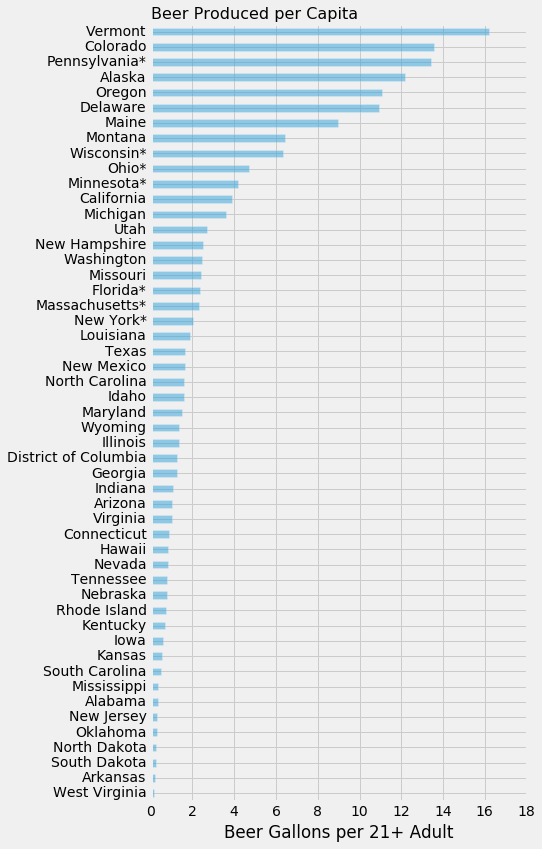

In [326]:
# plot beer produced with labels and titles
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
BAdata_states['Gallons Produced /21+ Adult'].plot(ax=ax, kind='barh', alpha=0.5, figsize=(6,13))
ax.set_title('Beer Produced per Capita', loc='left', fontsize=16)
ax.set_xlabel('Beer Gallons per 21+ Adult')
ax.set_ylabel('')

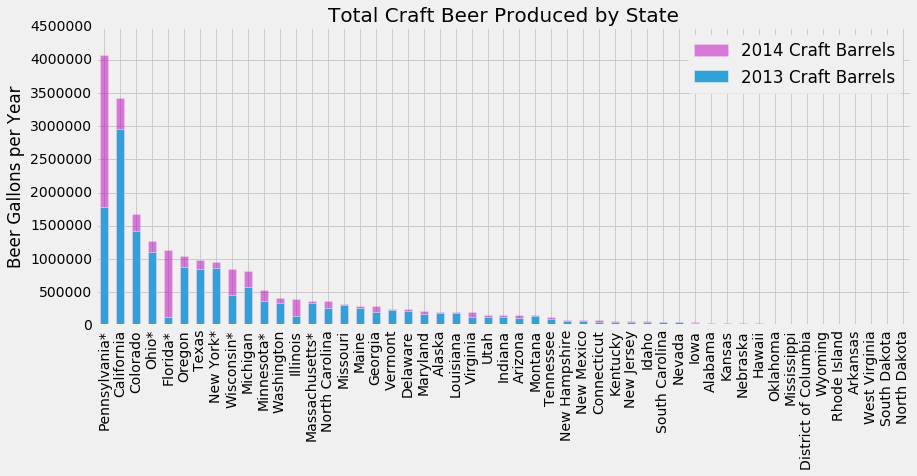

In [339]:
# rearrange production data for plotting total production information
BAdata_states = BAdata_states.sort_values(by=['2014 Craft Barrels'], ascending=[False])

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
BAdata_states['2014 Craft Barrels'].plot(ax=ax, kind='bar', alpha=0.5, figsize=(13,5),color='m') #2014 data
BAdata_states['2013 Craft Barrels'].plot(ax=ax, kind='bar', alpha=1, figsize=(13,5))             #2013 data
ax.set_title('Total Craft Beer Produced by State', loc='center', fontsize=20)                    #set title
ax.set_xlabel('')                                                                                #x-axis label
ax.set_ylabel('Beer Gallons per Year')                                                           #y-axis label
ax.legend(['2014 Craft Barrels', '2013 Craft Barrels'])                                          #legend